In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Clustering

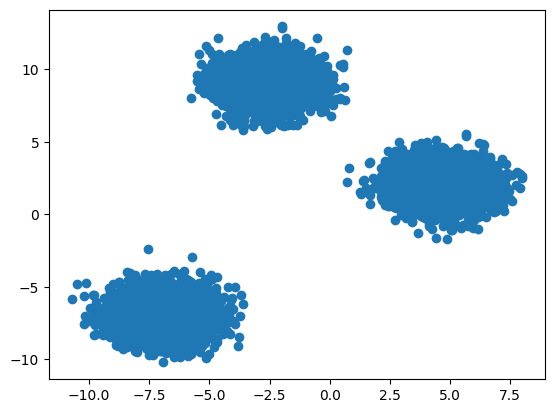

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(10000, 2, random_state=42)

plt.scatter(X[:, 0], X[:, 1])

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_predicted = kmeans.fit_predict(X)

Sometimes we can get an local optimum while running kmeans. We can solve this problem by running algorithm several times, and chose the best partition

In [4]:
k_means = KMeans(n_clusters=3, init=[...], n_init=10, random_state=42)

k-means is bad when working with non-spherical data

#### Image segmentation

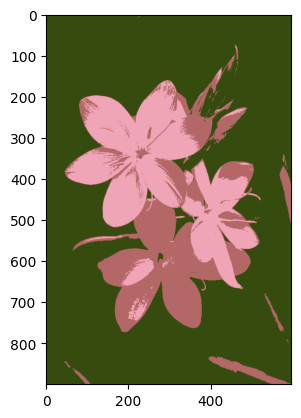

In [12]:
import PIL


image = np.asarray(PIL.Image.open('flower.jpg'))
X = image.reshape(-1, 3)

image_segmentation = KMeans(n_clusters=3, random_state=42).fit(X)

segmented_image = image_segmentation.cluster_centers_[image_segmentation.labels_]
segmented_image = segmented_image.reshape(image.shape) 
segmented_image = segmented_image.round(0)
segmented_image = PIL.Image.fromarray(np.uint8(segmented_image))
plt.imshow(segmented_image)

#### Clustering for Semi-Supervised learning

In [6]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Then we can manually label these representative digits and propagate those labels to all instances of the cluster. In such a way we can 
train LogisticRegression on this data and get approximately the same performance as with fully labeled data

### DBSCAN

1. For each data point we count how many instances are located within a small distance e 
2. If an instance has at least `min_samples` in neighbourhood then it is considered *core instance*
3. All instances that in the neighborhood of a core instance are in the same cluster, if other core instances are in this region, then one cluster is formed
4. Any instance that is not a core instance and do not belong to any neighborhood is considered as anomaly

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_
dbscan.core_sample_indices_
dbscan.components_

array([[ 1.57917965, -0.28141464],
       [-0.9759856 ,  0.11035157],
       [ 1.64517104, -0.34654927],
       ...,
       [ 0.41110926,  0.93473454],
       [ 0.79041803, -0.53286083],
       [ 0.77916988, -0.49014219]])

how to get new instance's cluster

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

### Gaussian Mixture

1. Each instance's cluster is randomly picked with probability of chosing $i$-th cluster is $\phi_i$
2. Then location of this instance $\mathbf{x}^{(i)}$ is chosen from $\mathbf{x}^{(i)} \sim \mathscr{N}(\mu^{(i)}, \Sigma^{(i)})$

In [9]:
from sklearn.mixture import GaussianMixture

gaussian_mixture = GaussianMixture(n_components=3, n_init=10)
gaussian_mixture.fit(X)

gaussian_mixture.weights_ # probabilities of choosing ith mixture
gaussian_mixture.means_  # mean of multivariate distribution
gaussian_mixture.covariances_ # covariances matrices

array([[[ 0.16171979, -0.09539419],
        [-0.09539419,  0.2877439 ]],

       [[ 0.05318455,  0.0618896 ],
        [ 0.0618896 ,  0.08915801]],

       [[ 0.06240474,  0.06754158],
        [ 0.06754158,  0.08947761]]])

In [10]:
gaussian_mixture.converged_ # check if algorithm converged
gaussian_mixture.n_item_  # check on which iteration it converged

AttributeError: 'GaussianMixture' object has no attribute 'n_item_'

In [37]:
gaussian_mixture.predict(X)
gaussian_mixture.predict_proba(X).round(3)

array([[0.001, 0.999, 0.   ],
       [0.11 , 0.   , 0.89 ],
       [1.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   ],
       [0.012, 0.   , 0.988],
       [0.916, 0.   , 0.084]])

Gaussian mixture is a generative algorithm meaning that is learns $P(X | Y)$ - so we can sample new data from it

In [45]:
X_new, y_new = gaussian_mixture.sample(6)
X_new

array([[ 1.16107911,  0.6751162 ],
       [ 0.92156135,  0.42084478],
       [ 0.51436501,  0.20179711],
       [ 0.55190981, -0.13342102],
       [ 0.51191599,  0.14204125],
       [ 0.52439097,  0.52197274]])

#### Selecting the number of clusters

to select appropriate number of clusters one can try to minimize *Theoretical information criterion*

1. Bayesian information criterion
2. Akaike information criterion

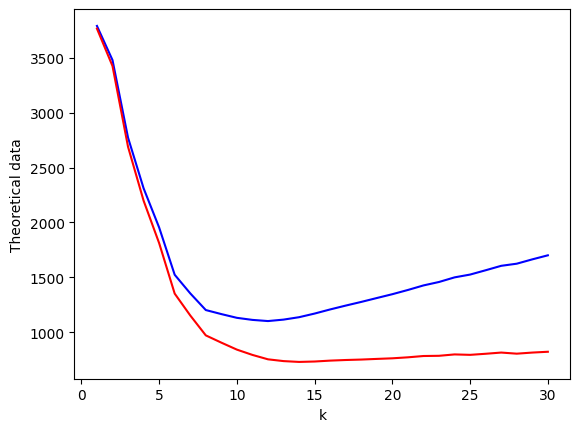

In [51]:

max_k = 30
models = [GaussianMixture(n_components=k, n_init=10).fit(X) for k in range(1, max_k+1)]
k_range = list(range(1, max_k+1))
bic_scores = [model.bic(X) for model in models]
aic_scores = [model.aic(X) for model in models]


plt.plot(k_range, bic_scores, 'b')
plt.plot(k_range, aic_scores, 'r')
plt.xlabel("k")
plt.ylabel("Theoretical data")

plt.show()

In [52]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2) # capable of identifying unnecessary clusters

/home/zhukowych/.virtualenvs/ml/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


array([0.12, 0.12, 0.15, 0.15, 0.11, 0.11, 0.12, 0.11, 0.  , 0.  ])